### AT RISK

In [68]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r"C:\Users\sachi\OneDrive\Documents\GitHub\Mentor_management_system\Week2\master_mmms.csv")

df['academic_attendance_percentage'] = df.apply(
    lambda row: (row['classes_attended'] / row['total_required_attendance']) * 100 if row['total_required_attendance'] > 0 else 0,
    axis=1
)
df['submitted_date'] = pd.to_datetime(df['submitted_date'])
df['submission_date'] = pd.to_datetime(df['submission_date'])

df['submission_delays'] = (df['submitted_date'] - df['submission_date'])

df['Conflict_Status'] = (
    (df['academic_attendance_percentage'] < 80) |
    ((df['submission_delays'] >= pd.Timedelta(days=3)) & (df['hours_per_week'] > 120))
).astype(int)

print("conflict_status_count:")
print(df['Conflict_Status'].value_counts())

print("\nFirst 5 rows with new percentage column:")
print(df[['student_id', 'classes_attended', 'total_required_attendance', 'academic_attendance_percentage']].head())


features = [
    'number_of_courses',
    'classes_attended',
    'assignment_grades',
    'no_of_tasks'
]

encoder = LabelEncoder()
df["assignment_grades"] = encoder.fit_transform(df['assignment_grades'])

X = df[features]
y = df['Conflict_Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape:{X_train.shape}")
print(f"Test set shape:{X_test.shape}")


model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
model.fit(X_train, y_train)

print("At risk model training complete.")

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]   


print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print("\n--- Confusion Matrix ---")
print("Top-left: True Negatives | Top-right: False Positives")
print("Bottom-left: False Negatives | Bottom-right: True Positives")
print(confusion_matrix(y_test, y_pred))


importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n--- Feature Importances ---")
print("The most important factors the model used for its predictions:")
print(importances)


print("Hours per Week vs Conflict Status")
plt.figure(figsize=(4,3))
sns.histplot(data=df, x='hours_per_week', hue='Conflict_Status', multiple='stack', palette='mako')
plt.title("Hours per Week vs Conflict Status")
plt.xlabel("Hours per Week")
plt.ylabel("Count")
plt.show()

print("Number of Tasks vs Conflict Status")
plt.figure(figsize=(4,3))
sns.histplot(data=df, x='no_of_tasks', hue='Conflict_Status', multiple='stack', palette='Set2')
plt.title("Number of Tasks vs Conflict Status")
plt.xlabel("Number of Tasks")
plt.ylabel("Count")
plt.show()

print("Residual Plot")
residuals = y_test - y_pred
plt.figure(figsize=(4,3))
sns.histplot(residuals, kde=True, bins=20, color="red")
plt.title("Residual Plot (Random Forest)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

print(" ROC Curve")
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="blue")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

print("Probability Plot")
plt.figure(figsize=(4,3))
sns.histplot(y_prob, bins=20, kde=True, color="blue")
plt.title("Predicted Probability Distribution")
plt.xlabel("Predicted Probability of Conflict Status = 1")
plt.ylabel("Count")
plt.show()

print(" Forest Plot (Feature Importances)")
plt.figure(figsize=(4,3))
sns.barplot(x=importances, y=importances.index)
plt.title("Forest Plot - Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


conflict_status_count:
Conflict_Status
1    133
0     67
Name: count, dtype: int64

First 5 rows with new percentage column:
  student_id  classes_attended  total_required_attendance  \
0       S001                27                         30   
1       S002                28                         42   
2       S003                11                         20   
3       S004                42                         45   
4       S005                11                         12   

   academic_attendance_percentage  
0                       90.000000  
1                       66.666667  
2                       55.000000  
3                       93.333333  
4                       91.666667  
Training set shape:(160, 4)
Test set shape:(40, 4)
At risk model training complete.

--- Classification Report ---


c:\Users\sachi\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
c:\Users\sachi\anaconda3\Lib\ast.py:602: DeprecationWarning: Constant.__init__ got an unexpected keyword argument 's'. Support for arbitrary keyword arguments is deprecated and will be removed in Python 3.15.
  return Constant(*args, **kwargs)
c:\Users\sachi\anaconda3\Lib\ast.py:602: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
c:\Users\sachi\anaconda3\Lib\ast.py:602: DeprecationWarning: Constant.__init__ missing 1 required positional argument: 'value'. This will become an error in Python 3.15.
  return Constant(*args, **kwargs)
c:\Users\sachi\anaconda3\Lib\site-packages\executing\executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instea

ValueError: Classification metrics can't handle a mix of binary and continuous targets

### PASS OR FAIL

pass_fail counts:
pass_fail
0    157
1     43
Name: count, dtype: int64
trainig set size'(160, 5)
test set size'(40, 5)
model training complete
classification_report:
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        31
           1       0.50      0.11      0.18         9

    accuracy                           0.78        40
   macro avg       0.64      0.54      0.53        40
weighted avg       0.72      0.78      0.71        40

confusion_matrix:
TN | FP
FN | TP
[[30  1]
 [ 8  1]]
importance: 
hours_per_week             0.342031
classes_attended           0.267943
no_of_tasks                0.227005
num_mitigation_requests    0.103540
number_of_courses          0.059480
dtype: float64


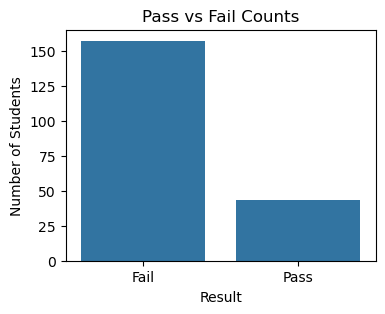

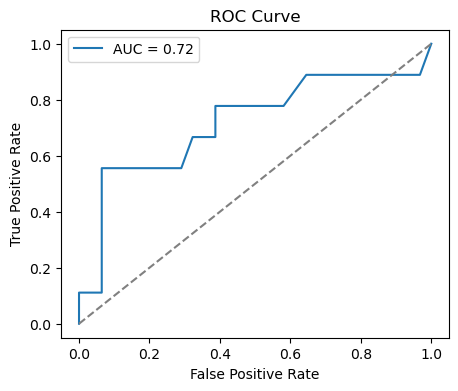

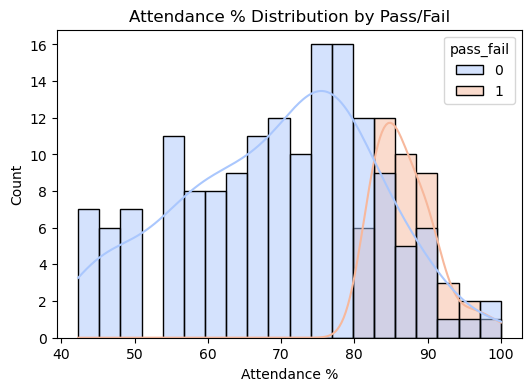

In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score


df = pd.read_csv(r'C:\Users\sachi\OneDrive\Documents\GitHub\Mentor_management_system\Week2\master_mmms.csv')

#attendance percentage

df['academic_attendance_percentage'] = df.apply(
    lambda row: (row['classes_attended'] / row['total_required_attendance']) * 100 , axis = 1
)


grade_map = {'A1': 5, 'A2': 4, 'B1': 3, 'B2': 2, 'C1': 1, 'C2': 1, 'Fail': 0}
df['assignment_grades'] = df['assignment_grades'].map(grade_map)


df['pass_fail'] = ((
    df['academic_attendance_percentage'] > 80) & (df['assignment_grades'] > 1)).astype(int)

print('pass_fail counts:')
print(df['pass_fail'].value_counts())

features = [
    'number_of_courses',
    'classes_attended',
    'hours_per_week',
    'no_of_tasks',
    'num_mitigation_requests',
    
]

x = df[features]
y = df['pass_fail']

x_train , x_test , y_train , y_test = train_test_split(
    x,y,test_size=0.2 ,random_state= 42,stratify=y
)

print(f"trainig set size'{x_train.shape}")
print(f"test set size'{x_test.shape}")

model = RandomForestClassifier(n_estimators=100 , random_state= 42 , class_weight= "balanced")
model.fit(x_train,y_train)

print("model training complete")

y_pred = model.predict(x_test)

print("classification_report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test,y_pred)
print("confusion_matrix:")
print("TN | FP\nFN | TP")
print(cm)


importances = pd.Series(model.feature_importances_,index = features)
importances = importances.sort_values(ascending=False)
print("importance: ")
print(importances)


plt.figure(figsize=(4,3))
sns.countplot(x='pass_fail', data=df)
plt.xticks([0, 1], ['Fail', 'Pass'])
plt.title('Pass vs Fail Counts')
plt.xlabel('Result')
plt.ylabel('Number of Students')
plt.show()


y_prob = model.predict_proba(x_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(data=df, x='academic_attendance_percentage', hue='pass_fail', kde=True, palette='coolwarm', bins=20)
plt.title("Attendance % Distribution by Pass/Fail")
plt.xlabel("Attendance %")
plt.ylabel("Count")
plt.show()


### GRADE PREDICTION

Leniar regression model trained
Mean Squared Error (MSE): 6.51
Mean Absolute Error (MAE): 2.10
R^2 Score: 0.97
0      C
1      C
2      C
3      A
4      C
      ..
195    C
196    B
197    B
198    A
199    C
Name: predicted_letter, Length: 200, dtype: object


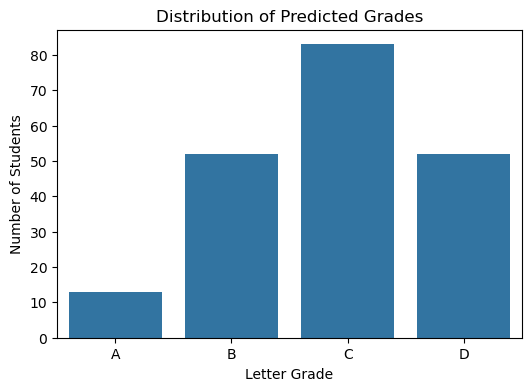

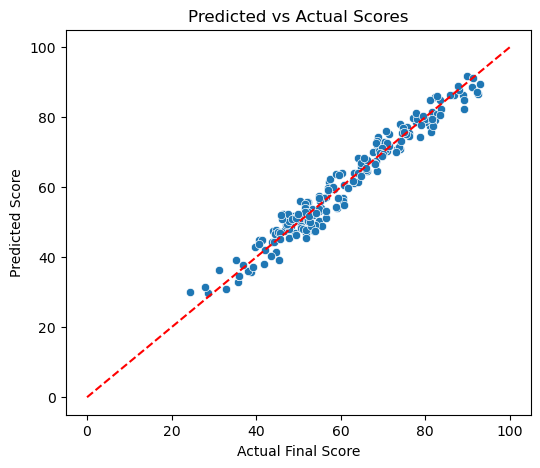

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(r'C:\Users\sachi\OneDrive\Documents\GitHub\Mentor_management_system\Week2\master_mmms.csv')

df['academic_attendance_percentage'] = df.apply(
    lambda row: (row['classes_attended'] / row['total_required_attendance'] * 100) , axis=1
)

grade_map = {'A1': 5, 'A2': 4, 'B1': 3, 'B2': 2, 'C1': 1, 'C2': 1, 'Fail': 0}
df['assignment_grades'] = df['assignment_grades'].map(grade_map)
df['assignment_score'] = (df['assignment_grades']/5)*100


df['activity_score'] = ((df['hours_per_week']/df['hours_per_week'].max())*50 + 
                        (df['no_of_tasks']/df['no_of_tasks'].max())*50 -
                        df['num_mitigation_requests']/df['num_mitigation_requests'].max()+1)

df['activity_score'] = df['activity_score'].clip(0, 100)


df['final_score'] = df['academic_attendance_percentage']*0.4 + df['assignment_score']*0.4 + df['activity_score']*0.2

df['attendance_ratio'] = (df['classes_attended']/df['total_required_attendance'])
df['mitigation_impact'] = (df['num_mitigation_requests']/(df['num_mitigation_requests'].max()+1))

features = [
    'number_of_courses',
    'classes_attended',
    'assignment_score',
    'attendance_ratio',
    'mitigation_impact',
]

x = df[features]
y = df['final_score']

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

x_train,x_test,y_train,y_test = train_test_split(
    x_scaled,y,test_size=0.2,random_state=42
)

model = LinearRegression()
model.fit(x_train, y_train)
print("Leniar regression model trained")

y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")

def score_to_grade(score):
    if score >= 85: return 'A'
    elif score >= 70: return 'B'
    elif score >= 50: return 'C'
    else: return 'D'
y_pred_full = model.predict(x_scaled)
df['predicted_grade'] = y_pred_full
df['predicted_letter'] = df['predicted_grade'].apply(score_to_grade)

print(df['predicted_letter'])

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='predicted_letter', order=['A','B','C','D'])
plt.title("Distribution of Predicted Grades")
plt.xlabel("Letter Grade")
plt.ylabel("Number of Students")
plt.show()


plt.figure(figsize=(6,5))
sns.scatterplot(x=df['final_score'], y=df['predicted_grade'])
plt.xlabel("Actual Final Score")
plt.ylabel("Predicted Score")
plt.title("Predicted vs Actual Scores")
plt.plot([0, 100], [0, 100], color='red', linestyle='--')  # ideal line
plt.show()


### Student - Mentor Conflicts

Conflict model training complete
              precision    recall  f1-score   support

           0       0.33      0.29      0.31         7
           1       0.85      0.88      0.87        33

    accuracy                           0.78        40
   macro avg       0.59      0.58      0.59        40
weighted avg       0.76      0.78      0.77        40

---Important features for conflict detection---
communication_gap             0.650443
academic_mentor_id            0.143077
industry_mentor_id            0.106835
academic_mentor_university    0.033265
industry_mentor_employer      0.066380
dtype: float64


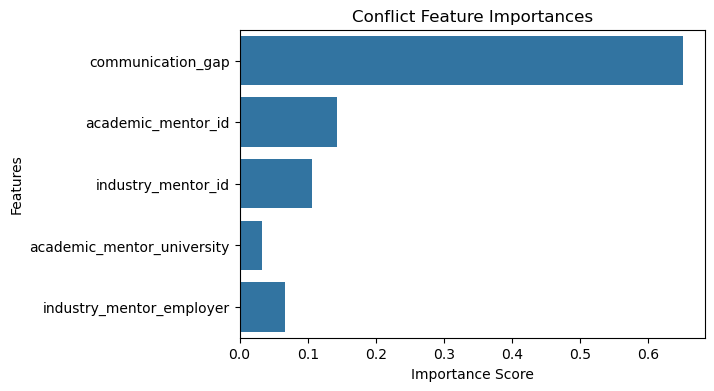

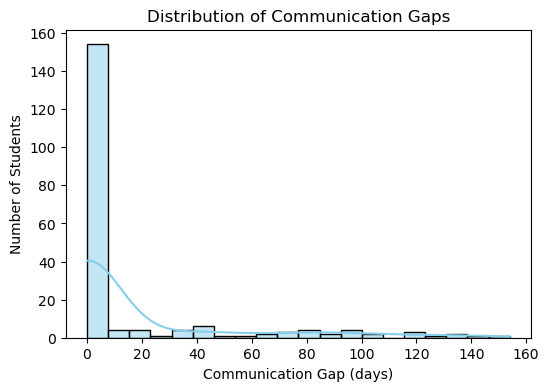

In [65]:

# ----- Conflict Features -----

# 1. Meeting cancelled (industry meeting missing)
df['industry_meeting_cancelled'] = df['industry_meeting_date'].isna().astype(int)

df['academic_meeting_cancelled'] = df['academic_meeting_date'].isna().astype(int)


# 3. Communication gap (if only one meeting date available)
df['academic_meeting_date'] = pd.to_datetime(df['academic_meeting_date'])
df['industry_meeting_date'] = pd.to_datetime(df['industry_meeting_date'])

# Gap = difference between academic and industry dates (if both exist)
df['communication_gap'] = (
    (df['academic_meeting_date'] - df['industry_meeting_date'])
    .dt.days.fillna(0).abs()
)

# 4. Conflict keywords
conflict_keywords = ["miscommunication", "unavailability", "delay", "postpone","canceled"]
df['conflict_keywords'] = df['reason'].str.lower().apply(
    lambda x: 1 if any(word in str(x) for word in conflict_keywords) else 0
)

# ----- Conflict Target (binary: 1 = conflict, 0 = no conflict) -----
df['Conflict'] = np.where(
    (df['industry_meeting_cancelled'] == 1) |
    (df['conflict_keywords'] == 1) |
    (df['academic_meeting_cancelled'] == 1) ,
    1, 0
)

# ----- Train Conflict Detection Model -----
conflict_features = [
    'communication_gap',
    'academic_mentor_id',
    'industry_mentor_id',
    'academic_mentor_university',
    'industry_mentor_employer'
]

df["academic_mentor_university"] = encoder.fit_transform(df['academic_mentor_university'])
df["industry_mentor_id"] = encoder.fit_transform(df['industry_mentor_id'])
df["academic_mentor_id"] = encoder.fit_transform(df['academic_mentor_id'])
df["industry_mentor_employer"] = encoder.fit_transform(df['industry_mentor_employer'])


x_conf = df[conflict_features]
y_conf = df['Conflict']

x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(
    x_conf, y_conf, test_size=0.2, random_state=42, stratify=y_conf
)

conflict_model = RandomForestClassifier(n_estimators=100, random_state=42)
conflict_model.fit(x_train_c, y_train_c)

print("Conflict model training complete")
y_pred_c = conflict_model.predict(x_test_c)
print(classification_report(y_test_c, y_pred_c))

# Feature importance
conf_importances = pd.Series(conflict_model.feature_importances_, index=x_conf.columns)
print("---Important features for conflict detection---")
print(conf_importances)

plt.figure(figsize=(6,4))
sns.barplot(x=conf_importances.values, y=conf_importances.index)
plt.title("Conflict Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()


plt.figure(figsize=(6,4))
sns.histplot(df['communication_gap'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Communication Gaps")
plt.xlabel("Communication Gap (days)")
plt.ylabel("Number of Students")
plt.show()


### Mitigation Request Patterns

Frequent Itemsets:
      support                                           itemsets
0   0.195402                         (Approved Leave (Vacation)
1   0.408046               (Corporate Overwork / High Workload)
2   0.160920            (Extension Approved by Academic Mentor)
3   0.413793                                 (Family Emergency)
4   0.413793                                (Medical Emergency)
5   0.155172                (Mental Health Leave / Counselling)
6   0.149425  (Mentor Unavailability / Meeting Canceled by M...
7   0.160920  (Miscommunication or Delay in Assignment Commu...
8   0.143678                   (Visa or Legal Paperwork Delays)
9   0.195402                                         (Wedding))
10  0.195402               (Approved Leave (Vacation, Wedding))
11  0.155172  (Family Emergency, Corporate Overwork / High W...
12  0.195402  (Medical Emergency, Corporate Overwork / High ...
13  0.137931              (Medical Emergency, Family Emergency)

Association Rules:


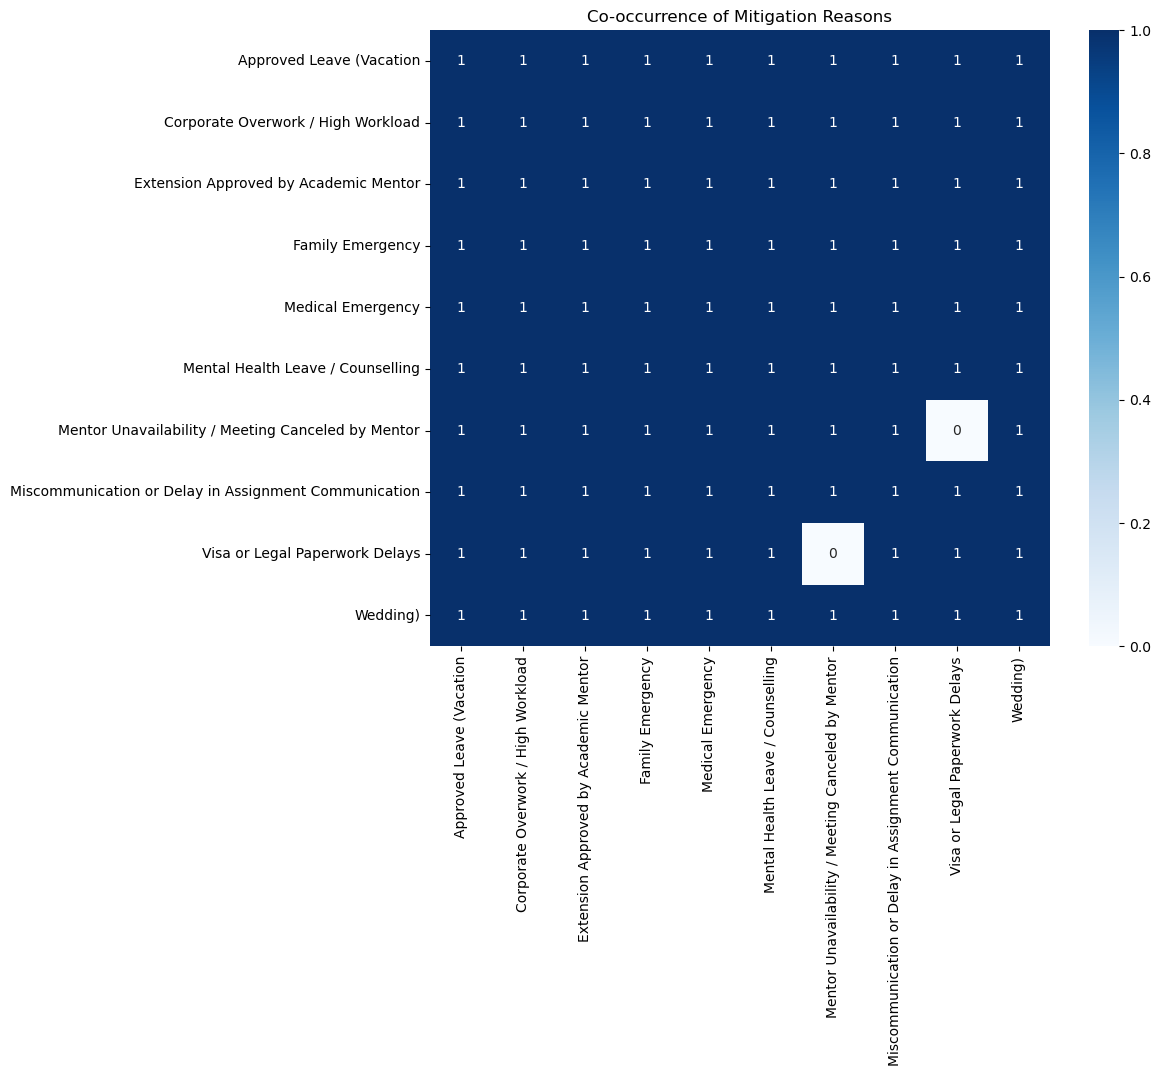

In [66]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r"C:\Users\sachi\OneDrive\Documents\GitHub\Mentor_management_system\Week2\master_mmms.csv")

# Keep only relevant columns
mitigation_df = df[['student_id', 'reason']].copy()

# Fill missing values
mitigation_df['reason'] = mitigation_df['reason'].fillna('None').astype(str)

# Replace internal commas inside reasons with semicolons to prevent splitting issues
mitigation_df['reason'] = mitigation_df['reason'].str.replace(r',', ';')

# Split multiple reasons into a list
mitigation_df['reason_list'] = mitigation_df['reason'].apply(
    lambda x: [r.strip() for r in x.split(';')] if x != 'None' else []
)

# Remove empty transactions
transactions = [t for t in mitigation_df['reason_list'].tolist() if len(t) > 0]

# One-hot encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Apply Apriori to find frequent itemsets
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

# Sort rules by confidence
rules = rules.sort_values(by='confidence', ascending=False)

# Display results
print("Frequent Itemsets:\n", frequent_itemsets)
print("\nAssociation Rules:\n", rules[[ 'antecedents', 'consequents','support', 'confidence', 'lift']])

# Take top 10 rules for plotting
top_rules = rules.head(10).copy()


# Create a co-occurrence matrix
co_occur = df_encoded.T.dot(df_encoded)
plt.figure(figsize=(10,8))
sns.heatmap(co_occur, annot=True, cmap='Blues')
plt.title('Co-occurrence of Mitigation Reasons')
plt.show()
